In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from imblearn.over_sampling import SMOTE
from ucimlrepo import fetch_ucirepo

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

Data Loading and Preprocessing

In [3]:
def load_and_preprocess_adult():
    """Load and preprocess the Adult dataset."""
    adult = fetch_ucirepo(id=2)
    x_adult = adult.data.features.copy()
    y_adult = adult.data.targets.copy()
    y_adult['income'] = y_adult['income'].str.strip('.')
    adult_data = pd.concat([x_adult, y_adult], axis=1)
    
    for column in ['workclass', 'occupation', 'native-country']:
        adult_data.loc[adult_data[column] == '?', column] = float('nan')
        mode_value = adult_data[column].mode()[0]
        adult_data.loc[:, column] = adult_data[column].fillna(mode_value)
    
    label = LabelEncoder()
    adult_data['sex'] = label.fit_transform(adult_data['sex'])
    adult_data['income'] = label.fit_transform(adult_data['income'])
    adult_data = pd.get_dummies(adult_data, columns=['workclass', 'marital-status', 'education', 'occupation', 'relationship', 'race', 'native-country'], drop_first=True)
    
    X_adult = adult_data.drop('income', axis=1)
    y_adult = adult_data['income']
    
    return X_adult, y_adult

def load_and_preprocess_bank():
    """Load and preprocess the Bank Marketing dataset."""
    bank_marketing = fetch_ucirepo(id=222)
    x_bank = bank_marketing.data.features.copy()
    y_bank = bank_marketing.data.targets.copy()
    bank_data = pd.concat([x_bank, y_bank], axis=1)
    
    for column in ['job', 'contact', 'poutcome']:
        mode_value = bank_data[column].mode()[0]
        bank_data.loc[:, column] = bank_data[column].fillna(mode_value)
    
    bank_data = pd.get_dummies(bank_data, columns=['job', 'marital', 'education', 'month', 'poutcome'], drop_first=True)
    binary_columns = ['default', 'housing', 'loan', 'contact', 'y']
    label = LabelEncoder()
    for col in binary_columns:
        bank_data[col] = label.fit_transform(bank_data[col])
    
    X_bank = bank_data.drop('y', axis=1)
    y_bank = bank_data['y']
    
    return X_bank, y_bank
# Load and preprocess datasets
X_adult, y_adult = load_and_preprocess_adult()
X_bank, y_bank = load_and_preprocess_bank()

# Split datasets
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(X_adult, y_adult, test_size=0.20, random_state=42)
X_bank_train, X_bank_test, y_bank_train, y_bank_test = train_test_split(X_bank, y_bank, test_size=0.20, random_state=43)

# Scale features
scaler = StandardScaler()
X_adult_train = scaler.fit_transform(X_adult_train)
X_adult_test = scaler.transform(X_adult_test)
X_bank_train = scaler.fit_transform(X_bank_train)
X_bank_test = scaler.transform(X_bank_test)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_adult_train, y_adult_train = smote.fit_resample(X_adult_train, y_adult_train)
X_bank_train, y_bank_train = smote.fit_resample(X_bank_train, y_bank_train)

Clustering Algorithms


Clustering Evaluation for Adult dataset:
K-Means - Silhouette: 0.0609, Calinski-Harabasz: 1259.3310
EM      - Silhouette: -0.0010, Calinski-Harabasz: 861.2603


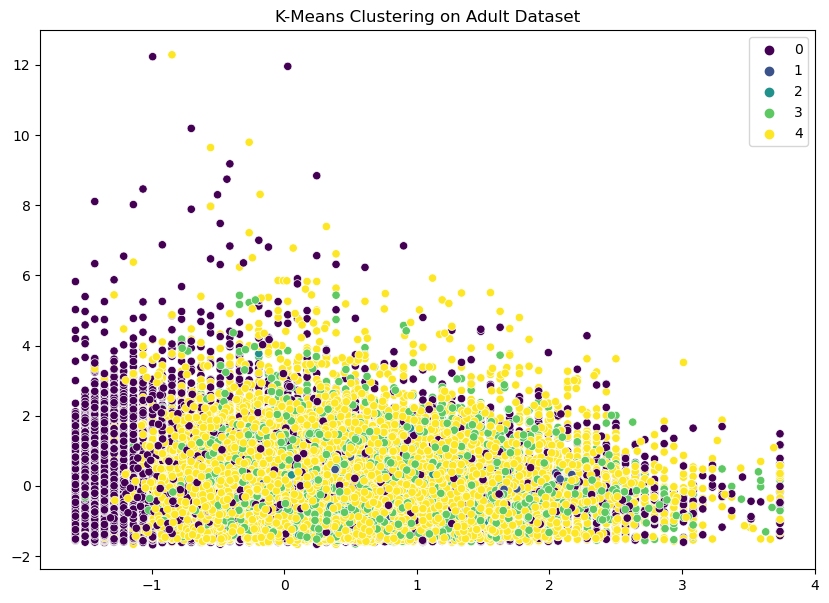

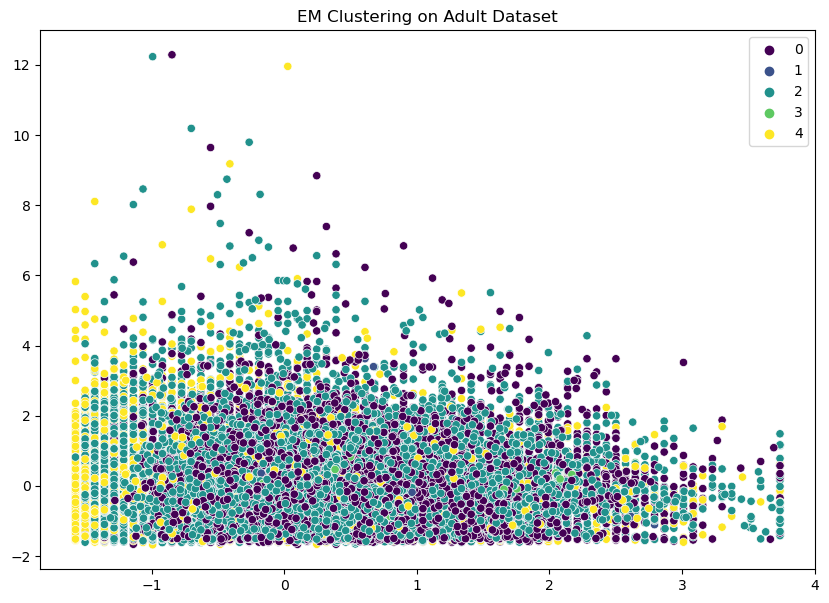


Clustering Evaluation for Bank dataset:
K-Means - Silhouette: 0.0946, Calinski-Harabasz: 4104.0153
EM      - Silhouette: 0.0280, Calinski-Harabasz: 2791.8249


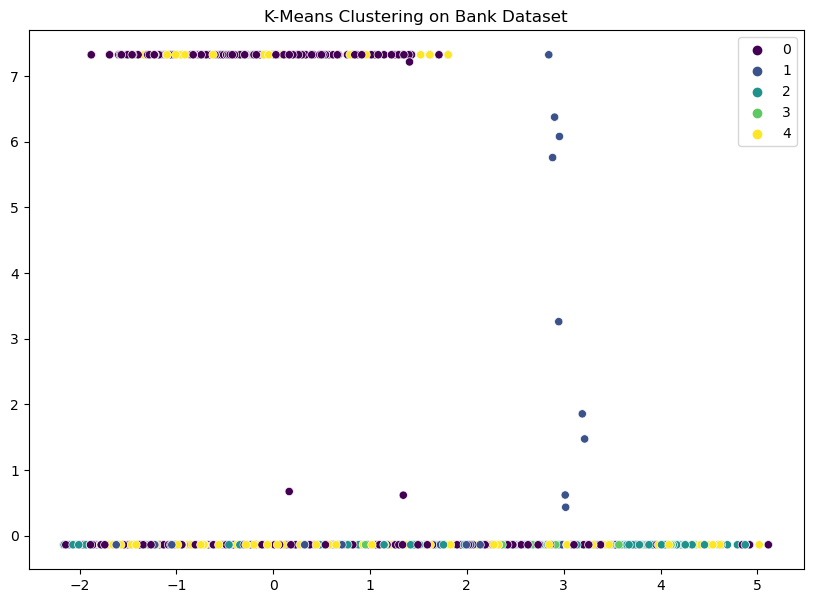

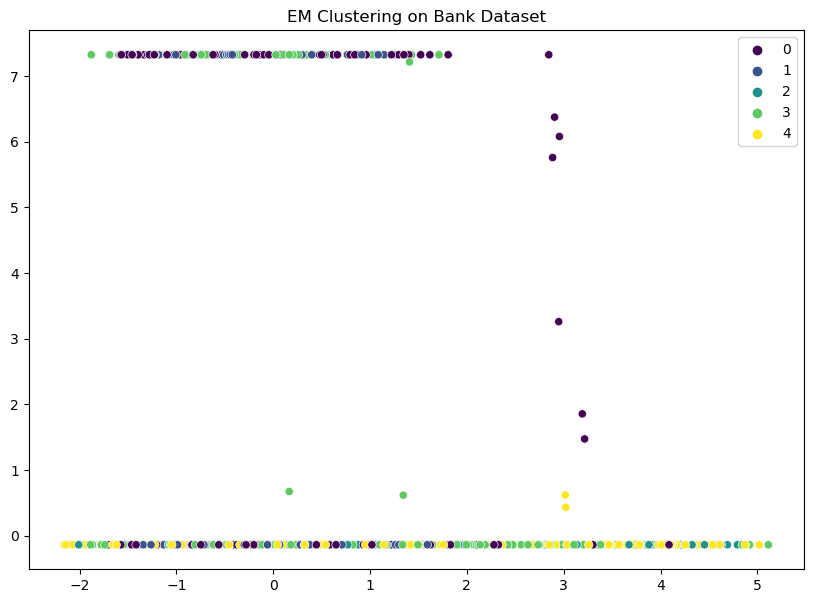

In [4]:
def kmeans_clustering(X, n_clusters=5):
    """Perform K-Means clustering."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    return labels, kmeans

def em_clustering(X, n_components=5):
    """Perform Expectation Maximization clustering using Gaussian Mixture Models."""
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    labels = gmm.fit_predict(X)
    return labels, gmm

def evaluate_clustering(X, labels):
    """Evaluate clustering results using silhouette score and Calinski-Harabasz index."""
    silhouette = silhouette_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    return silhouette, calinski_harabasz

def plot_clusters(X, labels, title):
    """Plot clustering results."""
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette="viridis")
    plt.title(title)
    plt.show()

# Perform clustering on Adult dataset
adult_kmeans_labels, adult_kmeans = kmeans_clustering(X_adult_train)
adult_em_labels, adult_em = em_clustering(X_adult_train)

# Perform clustering on Bank dataset
bank_kmeans_labels, bank_kmeans = kmeans_clustering(X_bank_train)
bank_em_labels, bank_em = em_clustering(X_bank_train)

# Evaluate and plot clustering results
for dataset, kmeans_labels, em_labels in [('Adult', adult_kmeans_labels, adult_em_labels),
                                          ('Bank', bank_kmeans_labels, bank_em_labels)]:
    X = X_adult_train if dataset == 'Adult' else X_bank_train
    
    kmeans_silhouette, kmeans_ch = evaluate_clustering(X, kmeans_labels)
    em_silhouette, em_ch = evaluate_clustering(X, em_labels)
    
    print(f"\nClustering Evaluation for {dataset} dataset:")
    print(f"K-Means - Silhouette: {kmeans_silhouette:.4f}, Calinski-Harabasz: {kmeans_ch:.4f}")
    print(f"EM      - Silhouette: {em_silhouette:.4f}, Calinski-Harabasz: {em_ch:.4f}")
    
    plot_clusters(X, kmeans_labels, f"K-Means Clustering on {dataset} Dataset")
    plot_clusters(X, em_labels, f"EM Clustering on {dataset} Dataset")

Dimensionality Reduction


Dimensionality Reduction Results for Adult dataset:
PCA Explained Variance Ratio:
   Principal Component  Explained Variance Ratio
0                    1                  0.040796
1                    2                  0.028772

ICA Kurtosis:
   Component  Kurtosis
0          1  0.511153
1          2  9.123921

RP Reconstruction Error:
                 Metric     Value
0  Reconstruction Error  0.929063


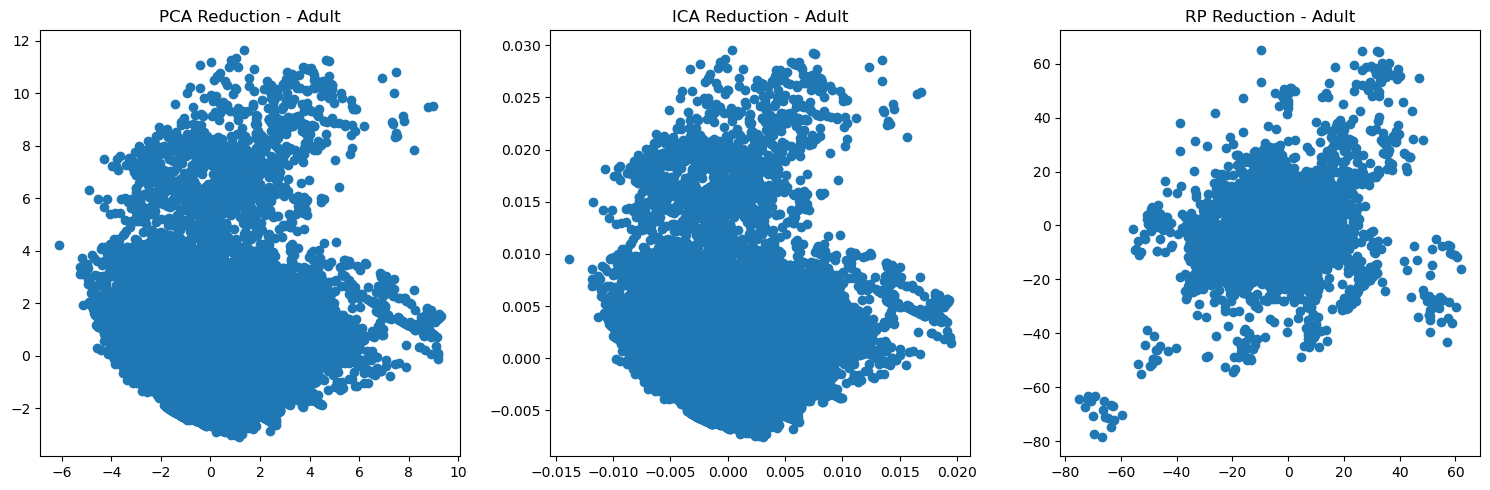


Dimensionality Reduction Results for Bank dataset:
PCA Explained Variance Ratio:
   Principal Component  Explained Variance Ratio
0                    1                  0.080952
1                    2                  0.065086

ICA Kurtosis:
   Component  Kurtosis
0          1  3.494011
1          2  1.015387

RP Reconstruction Error:
                 Metric    Value
0  Reconstruction Error  1.13831


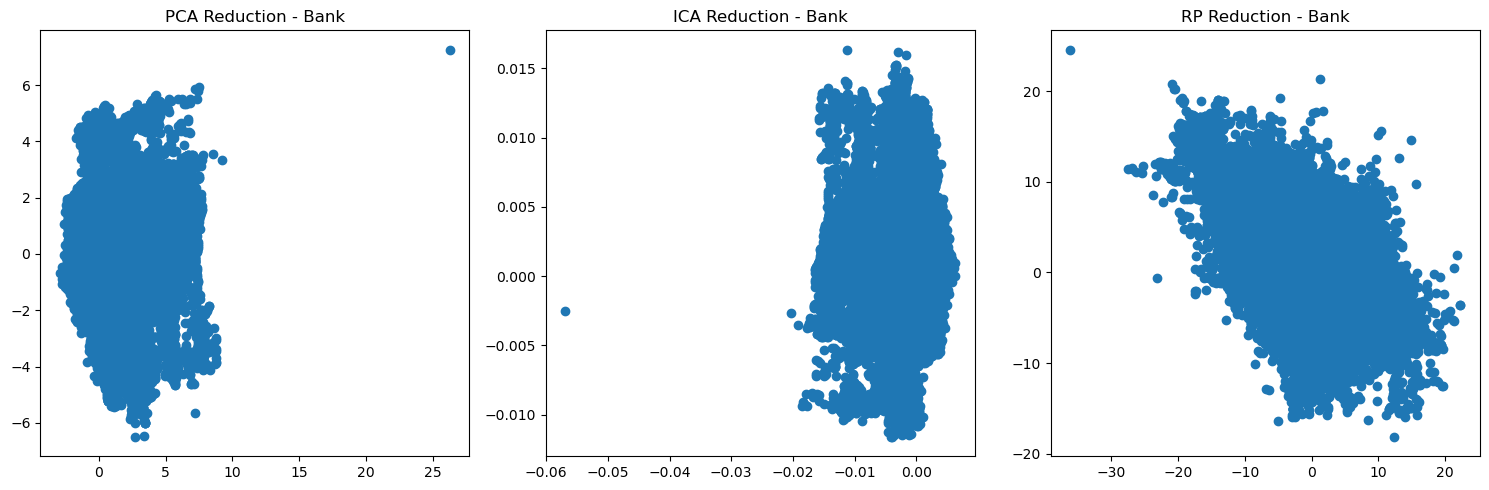

In [5]:
def pca_reduction(X, n_components=2):
    """Perform PCA dimensionality reduction."""
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    explained_variance_ratio = pd.DataFrame({
        'Principal Component': range(1, len(pca.explained_variance_ratio_) + 1),
        'Explained Variance Ratio': pca.explained_variance_ratio_
    })
    return X_reduced, explained_variance_ratio, pca

def ica_reduction(X, n_components=2):
    """Perform ICA dimensionality reduction."""
    ica = FastICA(n_components=n_components, random_state=42)
    X_reduced = ica.fit_transform(X)
    kurtosis_values = pd.DataFrame({
        'Component': range(1, X_reduced.shape[1] + 1),
        'Kurtosis': pd.DataFrame(X_reduced).kurtosis()
    })
    return X_reduced, kurtosis_values, ica

def rp_reduction(X, n_components=2):
    """Perform Random Projection dimensionality reduction."""
    rp = GaussianRandomProjection(n_components=n_components, random_state=42)
    X_reduced = rp.fit_transform(X)
    X_reconstructed = np.dot(X_reduced, np.linalg.pinv(rp.components_.T))
    reconstruction_error = np.mean(np.square(X - X_reconstructed))
    reconstruction_error_df = pd.DataFrame({
        'Metric': ['Reconstruction Error'],
        'Value': [reconstruction_error]
    })
    return X_reduced, reconstruction_error_df, rp

# Perform dimensionality reduction
for dataset, X in [('Adult', X_adult_train), ('Bank', X_bank_train)]:
    print(f"\nDimensionality Reduction Results for {dataset} dataset:")
    
    X_pca, pca_explained_variance, _ = pca_reduction(X)
    X_ica, ica_kurtosis, _ = ica_reduction(X)
    X_rp, rp_reconstruction_error, _ = rp_reduction(X)
    
    print("PCA Explained Variance Ratio:")
    print(pca_explained_variance)
    
    print("\nICA Kurtosis:")
    print(ica_kurtosis)
    
    print("\nRP Reconstruction Error:")
    print(rp_reconstruction_error)
    
    # Visualize reduced data
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.scatter(X_pca[:, 0], X_pca[:, 1])
    plt.title(f"PCA Reduction - {dataset}")
    plt.subplot(132)
    plt.scatter(X_ica[:, 0], X_ica[:, 1])
    plt.title(f"ICA Reduction - {dataset}")
    plt.subplot(133)
    plt.scatter(X_rp[:, 0], X_rp[:, 1])
    plt.title(f"RP Reduction - {dataset}")
    plt.tight_layout()
    plt.show()

Clustering on Dimensionality-Reduced Data

Performing clustering on dimensionality-reduced data:

Adult Dataset:
PCA:
  KMeans Silhouette Score: 0.3923
  EM Silhouette Score: 0.3257
ICA:
  KMeans Silhouette Score: 0.4111
  EM Silhouette Score: 0.3940
Random Projection:
  KMeans Silhouette Score: 0.3482
  EM Silhouette Score: 0.2850


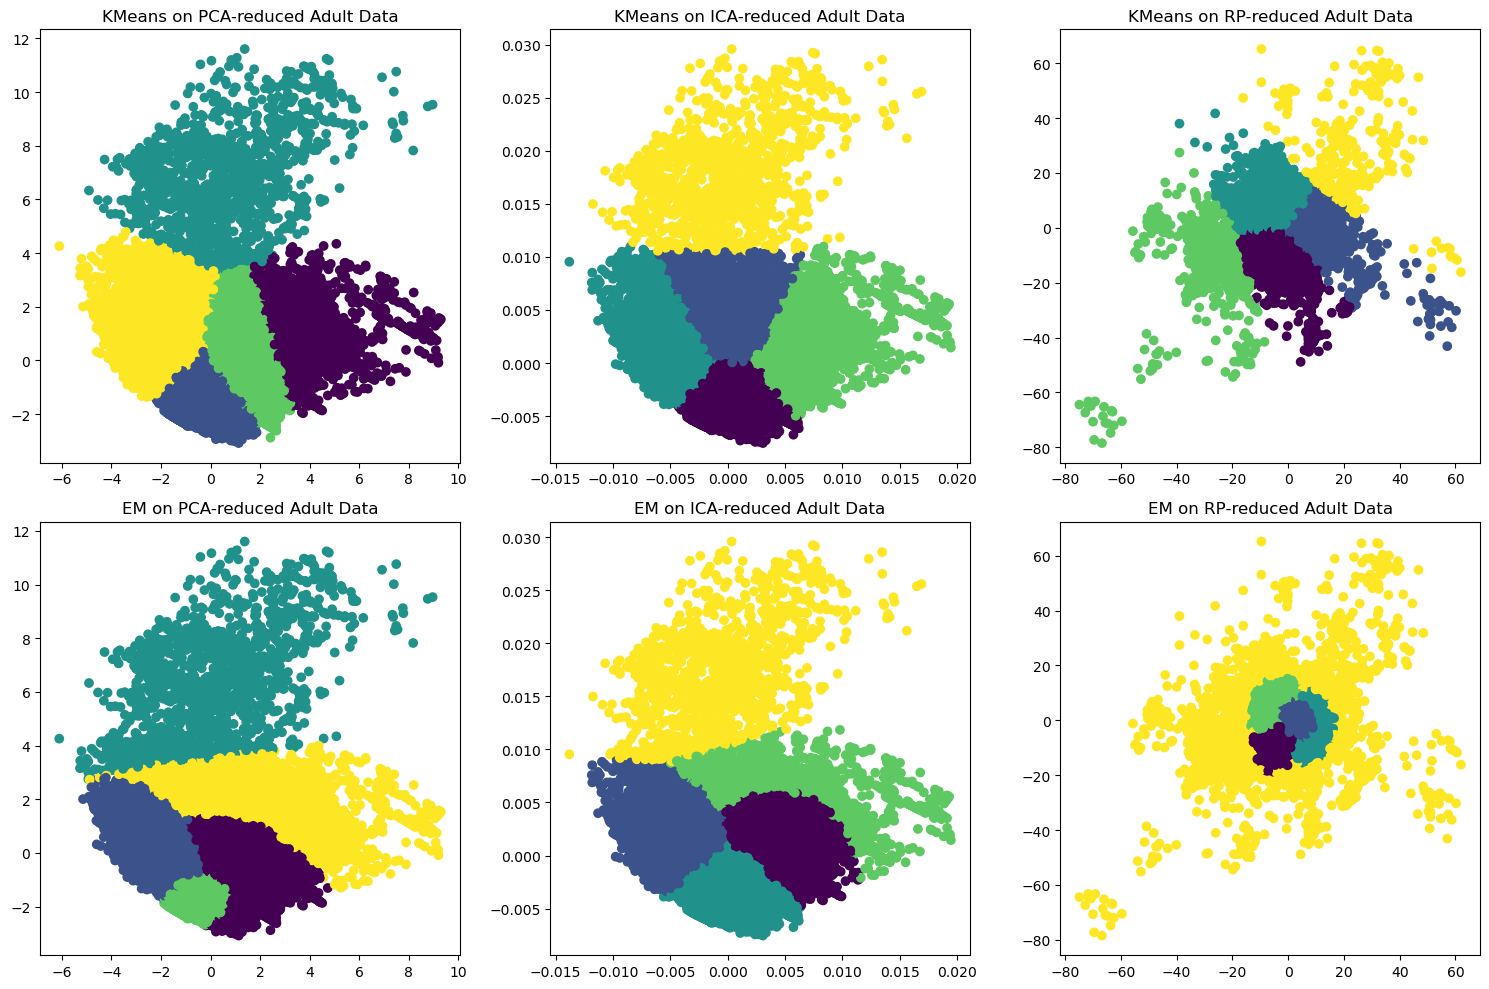


Bank Dataset:
PCA:
  KMeans Silhouette Score: 0.4579
  EM Silhouette Score: 0.3209
ICA:
  KMeans Silhouette Score: 0.4719
  EM Silhouette Score: 0.4539
Random Projection:
  KMeans Silhouette Score: 0.3307
  EM Silhouette Score: 0.3272


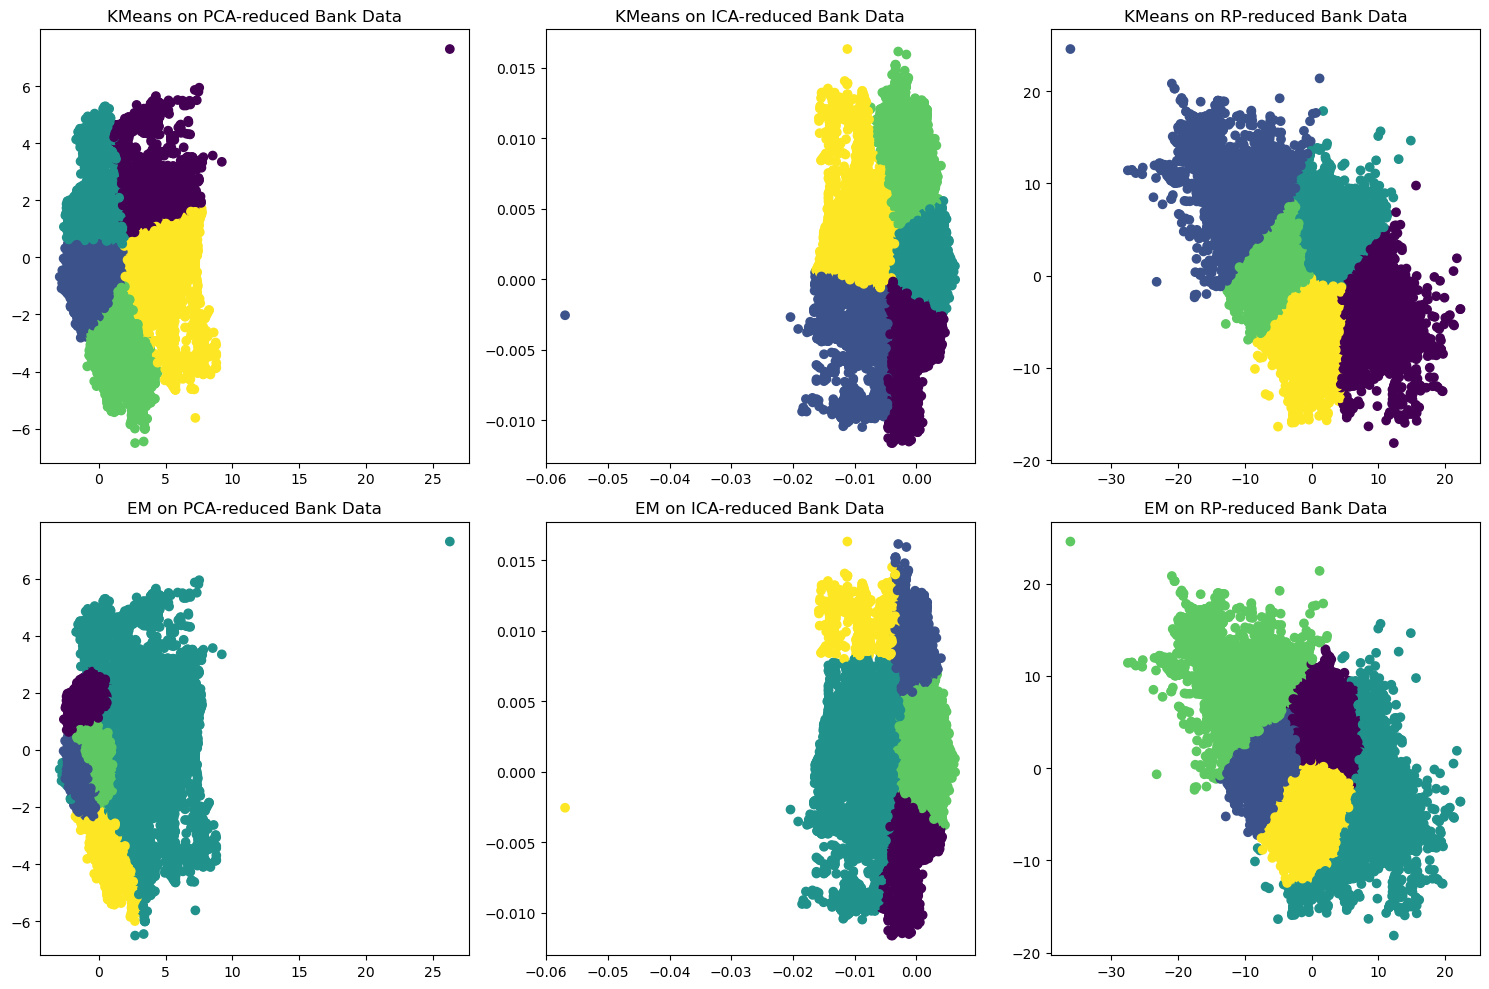

In [6]:
print("Performing clustering on dimensionality-reduced data:")

for dataset, X_train in [('Adult', X_adult_train), ('Bank', X_bank_train)]:
    print(f"\n{dataset} Dataset:")
    
    # PCA
    X_pca, _, _ = pca_reduction(X_train)
    kmeans_labels_pca = kmeans_clustering(X_pca)[0]
    em_labels_pca = em_clustering(X_pca)[0]
    print("PCA:")
    print(f"  KMeans Silhouette Score: {silhouette_score(X_pca, kmeans_labels_pca):.4f}")
    print(f"  EM Silhouette Score: {silhouette_score(X_pca, em_labels_pca):.4f}")
    
    # ICA
    X_ica, _, _ = ica_reduction(X_train)
    kmeans_labels_ica = kmeans_clustering(X_ica)[0]
    em_labels_ica = em_clustering(X_ica)[0]
    print("ICA:")
    print(f"  KMeans Silhouette Score: {silhouette_score(X_ica, kmeans_labels_ica):.4f}")
    print(f"  EM Silhouette Score: {silhouette_score(X_ica, em_labels_ica):.4f}")
    
    # Random Projection
    X_rp, _, _ = rp_reduction(X_train)
    kmeans_labels_rp = kmeans_clustering(X_rp)[0]
    em_labels_rp = em_clustering(X_rp)[0]
    print("Random Projection:")
    print(f"  KMeans Silhouette Score: {silhouette_score(X_rp, kmeans_labels_rp):.4f}")
    print(f"  EM Silhouette Score: {silhouette_score(X_rp, em_labels_rp):.4f}")

    # Visualize clustering results on reduced data
    plt.figure(figsize=(15, 10))
    
    # KMeans
    plt.subplot(231)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels_pca, cmap='viridis')
    plt.title(f'KMeans on PCA-reduced {dataset} Data')
    
    plt.subplot(232)
    plt.scatter(X_ica[:, 0], X_ica[:, 1], c=kmeans_labels_ica, cmap='viridis')
    plt.title(f'KMeans on ICA-reduced {dataset} Data')
    
    plt.subplot(233)
    plt.scatter(X_rp[:, 0], X_rp[:, 1], c=kmeans_labels_rp, cmap='viridis')
    plt.title(f'KMeans on RP-reduced {dataset} Data')
    
    # EM
    plt.subplot(234)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=em_labels_pca, cmap='viridis')
    plt.title(f'EM on PCA-reduced {dataset} Data')
    
    plt.subplot(235)
    plt.scatter(X_ica[:, 0], X_ica[:, 1], c=em_labels_ica, cmap='viridis')
    plt.title(f'EM on ICA-reduced {dataset} Data')
    
    plt.subplot(236)
    plt.scatter(X_rp[:, 0], X_rp[:, 1], c=em_labels_rp, cmap='viridis')
    plt.title(f'EM on RP-reduced {dataset} Data')
    
    plt.tight_layout()
    plt.show()

Neural Network Training and Evaluation


Neural Network Performance on Adult dataset:
Original Data - Train: 0.9119, Test: 0.8034
PCA Reduced  - Train: 0.7878, Test: 0.7482
ICA Reduced  - Train: 0.7822, Test: 0.7345
RP Reduced   - Train: 0.5904, Test: 0.5361

Neural Network Performance on Bank dataset:
Original Data - Train: 0.9566, Test: 0.8645
PCA Reduced  - Train: 0.6695, Test: 0.7525
ICA Reduced  - Train: 0.6507, Test: 0.7622
RP Reduced   - Train: 0.6264, Test: 0.7094


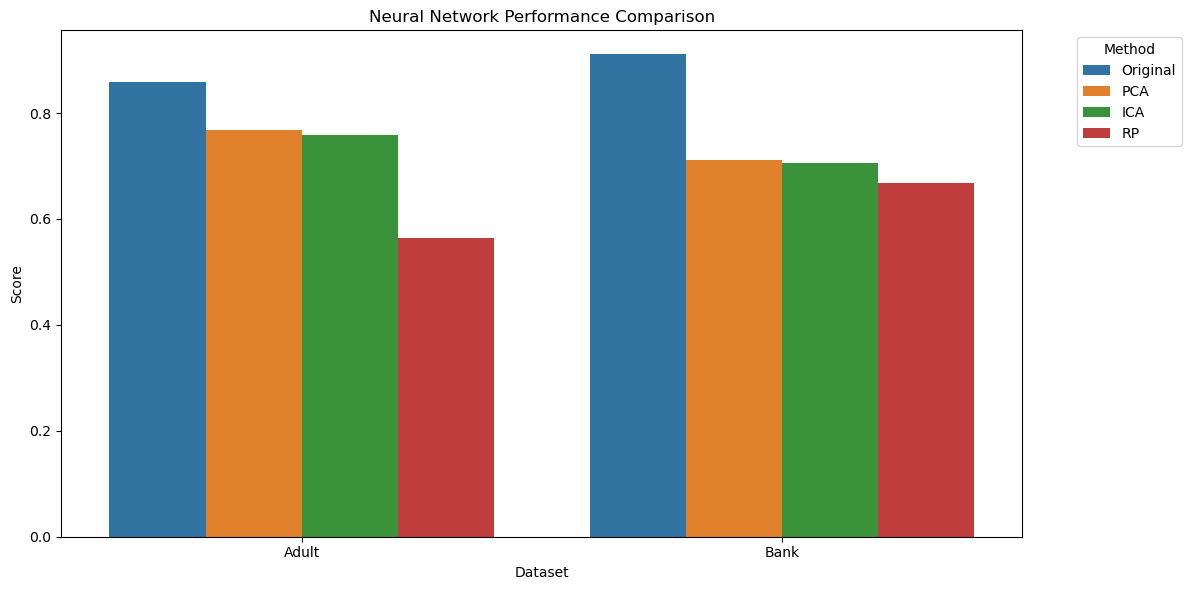

In [7]:
def train_nn(X_train, y_train, X_test, y_test):
    """Train and evaluate a neural network classifier."""
    nn = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.001,
                       learning_rate_init=0.001, max_iter=1000, random_state=43)
    nn.fit(X_train, y_train)
    train_score = nn.score(X_train, y_train)
    test_score = nn.score(X_test, y_test)
    return nn, train_score, test_score

# Lists to store results for plotting
datasets = []
methods = []
train_scores = []
test_scores = []

# Train and evaluate NN on original and reduced data
for dataset, X_train, y_train, X_test, y_test in [
    ('Adult', X_adult_train, y_adult_train, X_adult_test, y_adult_test),
    ('Bank', X_bank_train, y_bank_train, X_bank_test, y_bank_test)
]:
    print(f"\nNeural Network Performance on {dataset} dataset:")
    
    # Original data
    _, train_score, test_score = train_nn(X_train, y_train, X_test, y_test)
    print(f"Original Data - Train: {train_score:.4f}, Test: {test_score:.4f}")
    datasets.append(dataset)
    methods.append('Original')
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    # PCA reduced data
    X_pca, _, pca = pca_reduction(X_train)
    X_test_pca = pca.transform(X_test)
    _, train_score, test_score = train_nn(X_pca, y_train, X_test_pca, y_test)
    print(f"PCA Reduced  - Train: {train_score:.4f}, Test: {test_score:.4f}")
    datasets.append(dataset)
    methods.append('PCA')
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    # ICA reduced data
    X_ica, _, ica = ica_reduction(X_train)
    X_test_ica = ica.transform(X_test)
    _, train_score, test_score = train_nn(X_ica, y_train, X_test_ica, y_test)
    print(f"ICA Reduced  - Train: {train_score:.4f}, Test: {test_score:.4f}")
    datasets.append(dataset)
    methods.append('ICA')
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    # RP reduced data
    X_rp, _, rp = rp_reduction(X_train)
    X_test_rp = rp.transform(X_test)
    _, train_score, test_score = train_nn(X_rp, y_train, X_test_rp, y_test)
    print(f"RP Reduced   - Train: {train_score:.4f}, Test: {test_score:.4f}")
    datasets.append(dataset)
    methods.append('RP')
    train_scores.append(train_score)
    test_scores.append(test_score)

# Create a DataFrame for easier plotting
results_df = pd.DataFrame({
    'Dataset': datasets,
    'Method': methods,
    'Train Score': train_scores,
    'Test Score': test_scores
})

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='value', hue='Method', 
            data=pd.melt(results_df, id_vars=['Dataset', 'Method'], var_name='Score Type', value_name='value'),
            ci=None)
plt.title('Neural Network Performance Comparison')
plt.ylabel('Score')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Adding Clustering Labels as Features and Retraining NN


Neural Network Performance with Clustering Features on Adult dataset:
Original    - Train: 0.9119, Test: 0.8034
With KMeans - Train: 0.9004, Test: 0.8150
With EM     - Train: 0.9093, Test: 0.8098

Neural Network Performance with Clustering Features on Bank dataset:
Original    - Train: 0.9566, Test: 0.8645
With KMeans - Train: 0.9560, Test: 0.8664
With EM     - Train: 0.9607, Test: 0.8663


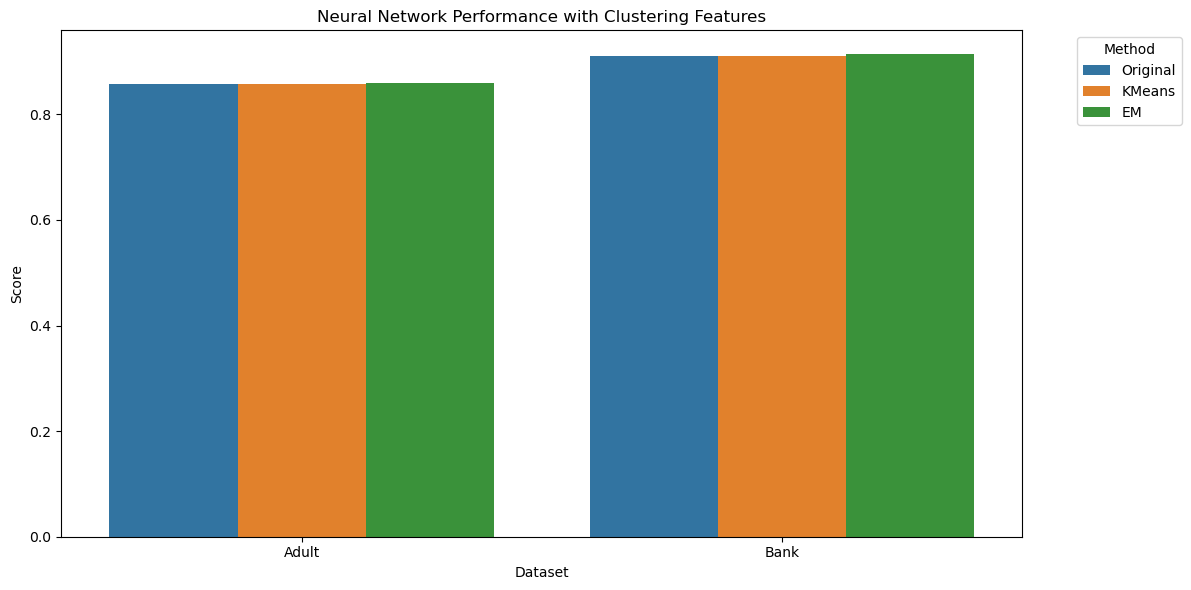

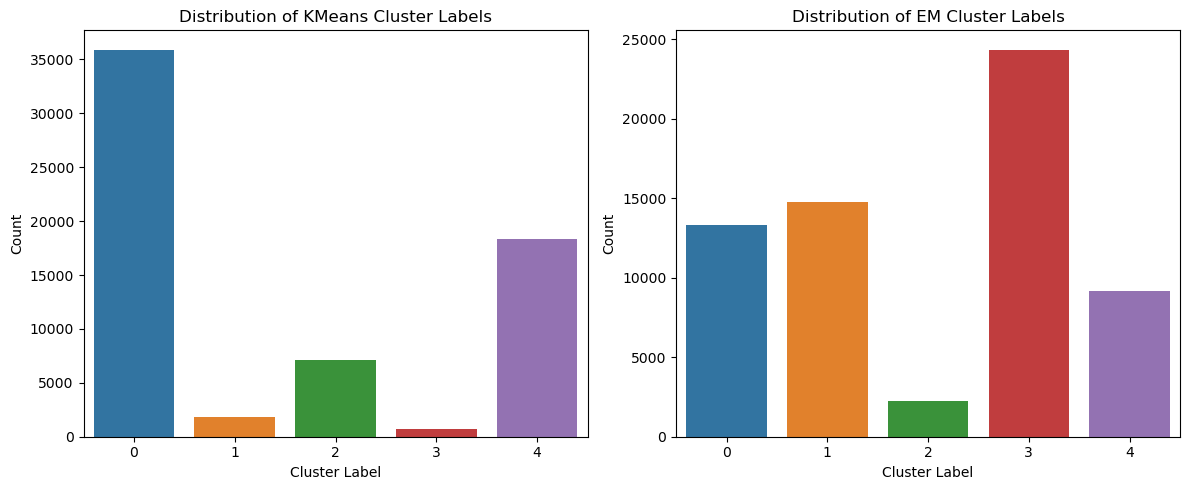

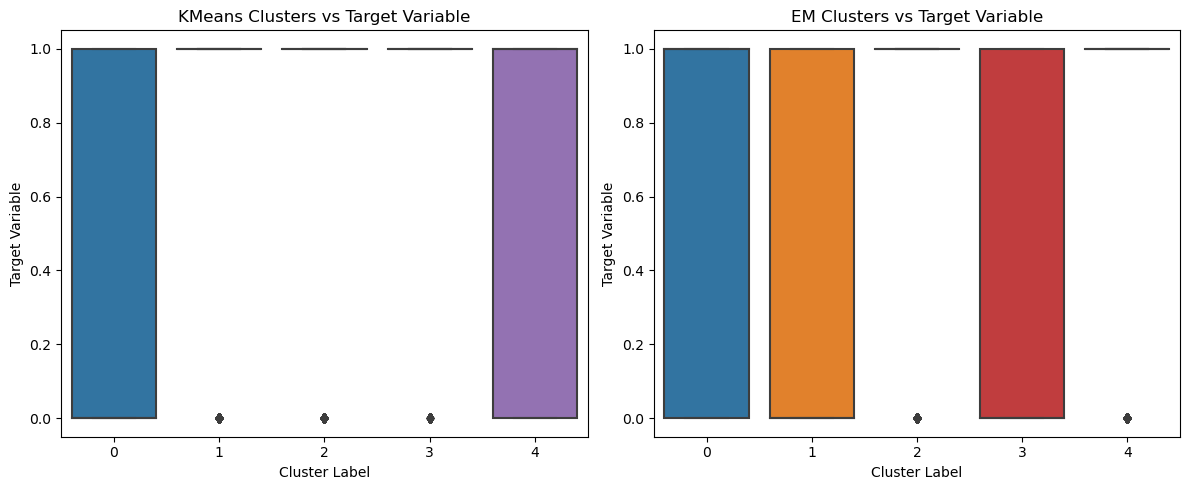

In [8]:
def add_cluster_labels(X, labels):
    """Add cluster labels as a new feature to the dataset."""
    return np.column_stack((X, labels))

# Lists to store results for plotting
datasets = []
methods = []
train_scores = []
test_scores = []

# Add clustering labels and retrain NN
for dataset, X_train, y_train, X_test, y_test in [
    ('Adult', X_adult_train, y_adult_train, X_adult_test, y_adult_test),
    ('Bank', X_bank_train, y_bank_train, X_bank_test, y_bank_test)
]:
    print(f"\nNeural Network Performance with Clustering Features on {dataset} dataset:")
    
    # Original data (baseline)
    _, train_score, test_score = train_nn(X_train, y_train, X_test, y_test)
    print(f"Original    - Train: {train_score:.4f}, Test: {test_score:.4f}")
    datasets.append(dataset)
    methods.append('Original')
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    # KMeans clustering
    kmeans_labels, kmeans = kmeans_clustering(X_train)
    X_train_kmeans = add_cluster_labels(X_train, kmeans_labels)
    X_test_kmeans = add_cluster_labels(X_test, kmeans.predict(X_test))
    _, train_score, test_score = train_nn(X_train_kmeans, y_train, X_test_kmeans, y_test)
    print(f"With KMeans - Train: {train_score:.4f}, Test: {test_score:.4f}")
    datasets.append(dataset)
    methods.append('KMeans')
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    # EM clustering
    em_labels, em = em_clustering(X_train)
    X_train_em = add_cluster_labels(X_train, em_labels)
    X_test_em = add_cluster_labels(X_test, em.predict(X_test))
    _, train_score, test_score = train_nn(X_train_em, y_train, X_test_em, y_test)
    print(f"With EM     - Train: {train_score:.4f}, Test: {test_score:.4f}")
    datasets.append(dataset)
    methods.append('EM')
    train_scores.append(train_score)
    test_scores.append(test_score)

# Create a DataFrame for easier plotting
results_df = pd.DataFrame({
    'Dataset': datasets,
    'Method': methods,
    'Train Score': train_scores,
    'Test Score': test_scores
})

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='value', hue='Method', 
            data=pd.melt(results_df, id_vars=['Dataset', 'Method'], var_name='Score Type', value_name='value'),
            ci=None)
plt.title('Neural Network Performance with Clustering Features')
plt.ylabel('Score')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize the distribution of cluster labels
plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.countplot(x=kmeans_labels)
plt.title('Distribution of KMeans Cluster Labels')
plt.xlabel('Cluster Label')
plt.ylabel('Count')

plt.subplot(122)
sns.countplot(x=em_labels)
plt.title('Distribution of EM Cluster Labels')
plt.xlabel('Cluster Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Visualize the relationship between cluster labels and target variable
plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.boxplot(x=kmeans_labels, y=y_train)
plt.title('KMeans Clusters vs Target Variable')
plt.xlabel('Cluster Label')
plt.ylabel('Target Variable')

plt.subplot(122)
sns.boxplot(x=em_labels, y=y_train)
plt.title('EM Clusters vs Target Variable')
plt.xlabel('Cluster Label')
plt.ylabel('Target Variable')

plt.tight_layout()
plt.show()

Few more visualizations to better understand our results

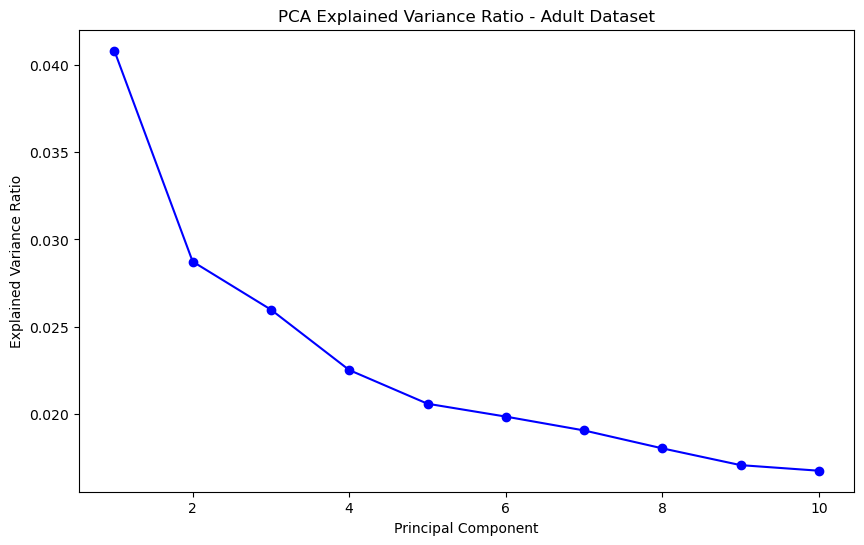

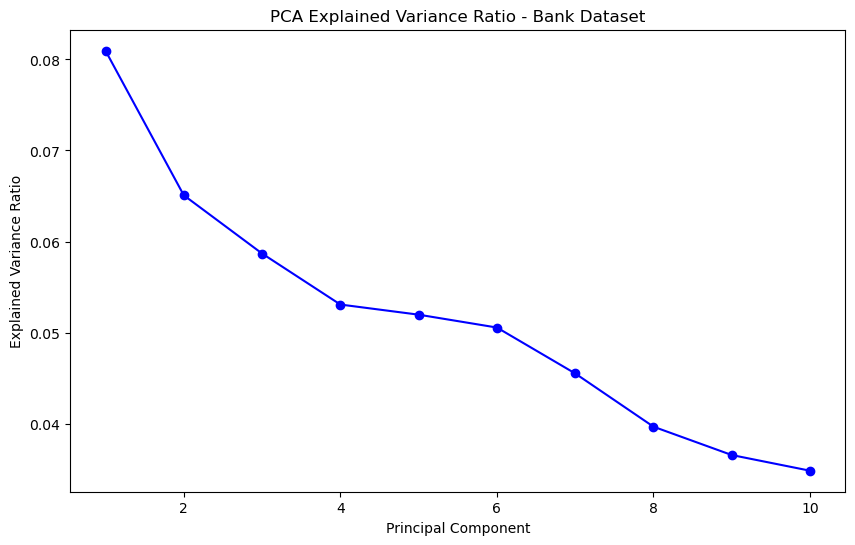

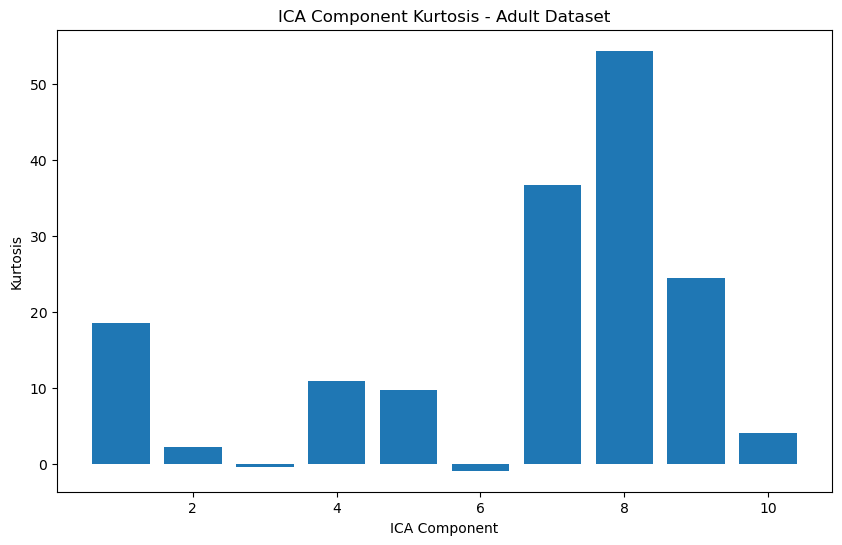

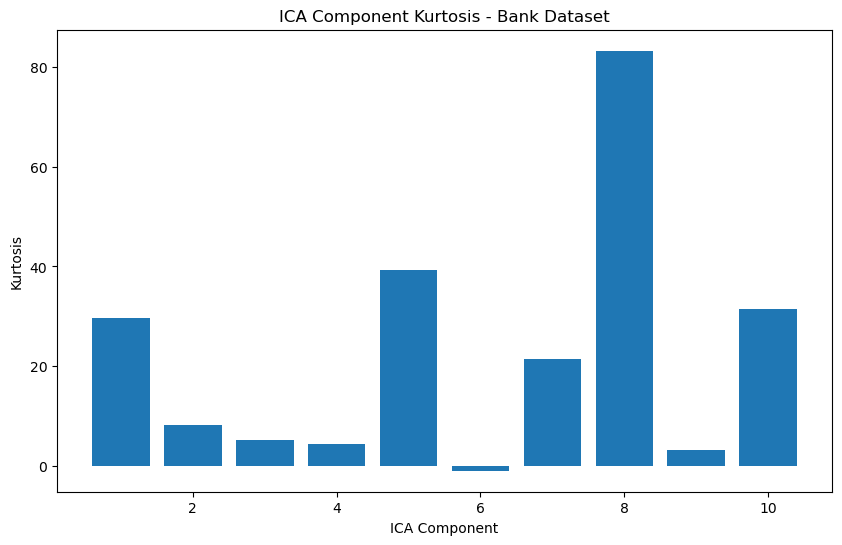

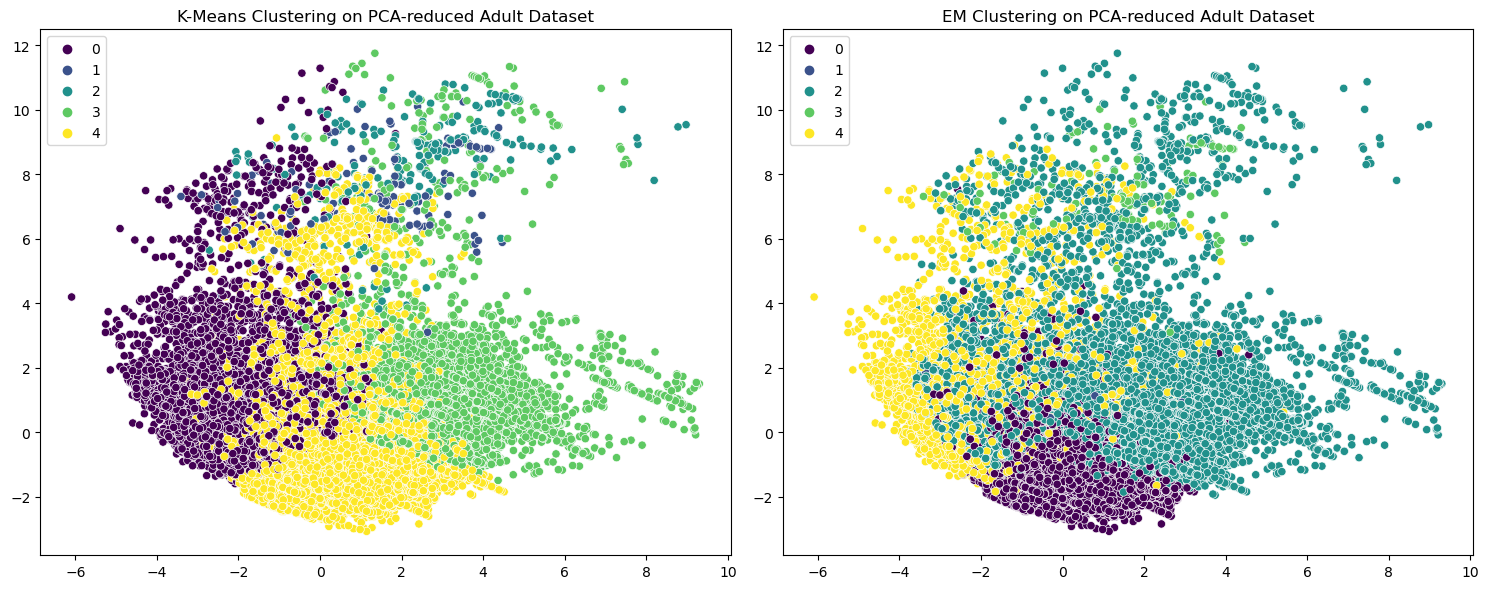

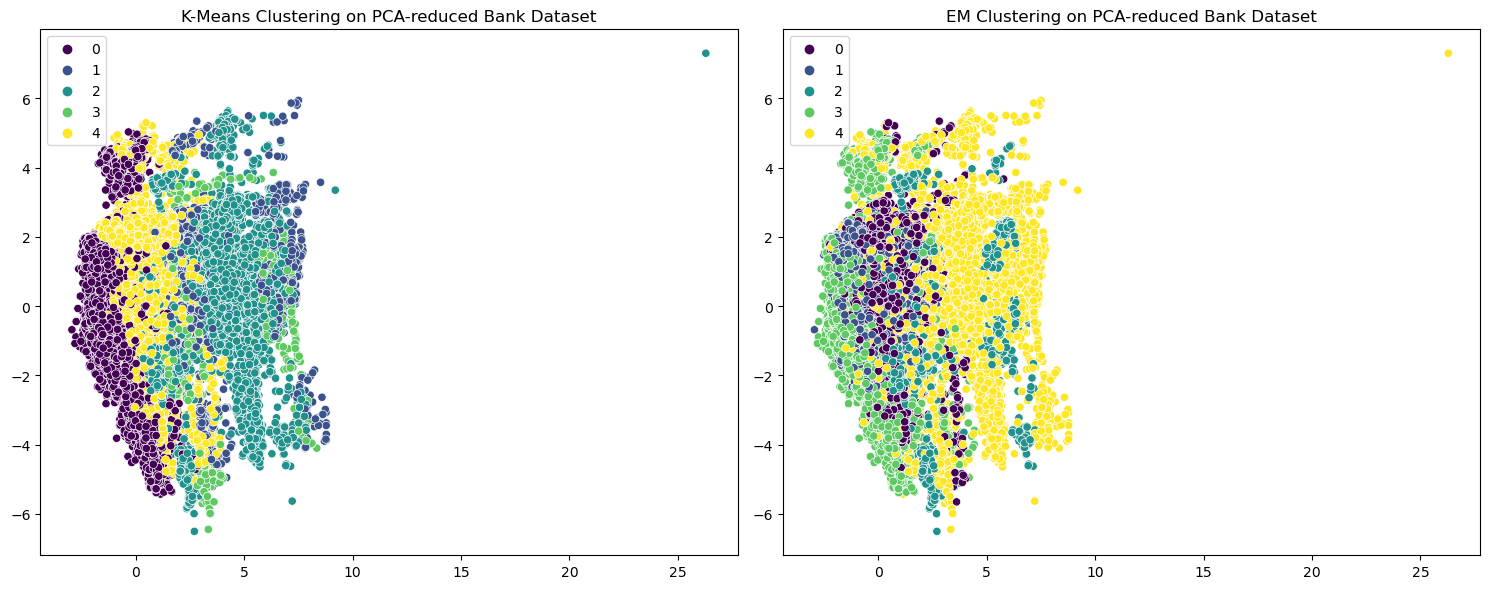

In [9]:
# Visualize PCA explained variance ratio
for dataset, X in [('Adult', X_adult_train), ('Bank', X_bank_train)]:
    _, pca_explained_variance, _ = pca_reduction(X, n_components=10)
    plt.figure(figsize=(10, 6))
    plt.plot(pca_explained_variance['Principal Component'], pca_explained_variance['Explained Variance Ratio'], 'bo-')
    plt.title(f'PCA Explained Variance Ratio - {dataset} Dataset')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

# Visualize ICA kurtosis
for dataset, X in [('Adult', X_adult_train), ('Bank', X_bank_train)]:
    _, ica_kurtosis, _ = ica_reduction(X, n_components=10)
    plt.figure(figsize=(10, 6))
    plt.bar(ica_kurtosis['Component'], ica_kurtosis['Kurtosis'])
    plt.title(f'ICA Component Kurtosis - {dataset} Dataset')
    plt.xlabel('ICA Component')
    plt.ylabel('Kurtosis')
    plt.show()

# Visualize clustering results with PCA
for dataset, X, kmeans_labels, em_labels in [
    ('Adult', X_adult_train, adult_kmeans_labels, adult_em_labels),
    ('Bank', X_bank_train, bank_kmeans_labels, bank_em_labels)
]:
    X_pca, _, _ = pca_reduction(X, n_components=2)
    
    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette="viridis")
    plt.title(f'K-Means Clustering on PCA-reduced {dataset} Dataset')
    
    plt.subplot(122)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=em_labels, palette="viridis")
    plt.title(f'EM Clustering on PCA-reduced {dataset} Dataset')
    
    plt.tight_layout()
    plt.show()